In [1]:
# inference and running script for FourCastNet

In [31]:
import argparse
import os
import sys
import time, re
import numpy as np
import logging
from collections import OrderedDict


username="gupt1075"
# sys.path.append(os.path.dirname(os.path.realpath(__file__)) + '/../')
if (f"/home/{username}/FourCastNet_gil" not in sys.path):
    sys.path.append(f"/home/{username}/FourCastNet_gil")





import h5py
import torch
import torch.cuda.amp as amp
import torch.distributed as dist
import torch.nn as nn
import torchvision
from numpy.core.numeric import False_
from torch.nn.parallel import DistributedDataParallel
from torchvision.utils import save_image
from utils.weighted_acc_rmse import (
    unweighted_acc_torch_channels,
    weighted_acc_masked_torch_channels,
    weighted_acc_torch_channels,
    weighted_rmse_torch_channels,
)

import glob
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import wandb
from utils import logging_utils
from networks.afnonet import AFNONet
from utils.data_loader_multifiles import get_data_loader
from utils.YParams import YParams
from scipy.stats import sem






In [25]:

def save_dataset(file, name, data, shape=None, dtype=None):
    """Helper function to save or overwrite a dataset in an HDF5 file."""
    try:
        file.create_dataset(name, data=data, shape=shape, dtype=dtype)
    except:
        del file[name]
        file.create_dataset(name, data=data, shape=shape, dtype=dtype)
        file[name][...] = data



In [26]:



def plot_time_series(arr, filepath, fld="z500", default_timedelta=6, start_year=2018):
    # Compute the mean across the rows of the time series at each of the total_hours time points
    means = np.mean(arr, axis=0)

    # Compute the total number of hours based on the array shape and default timedelta
    total_hours = arr.shape[1] * default_timedelta

    # Plot the mean values
    plt.plot(range(0, total_hours, default_timedelta), means, label=f'Mean of {fld} across {total_hours} hours for start_year {start_year}')
    
    # Compute the standard error of the mean (sem) at each time point
    sem_vals = sem(arr, axis=0)
    
    # Plot the 95% confidence interval for the mean values
    plt.fill_between(range(0, total_hours, default_timedelta), means - 1.96*sem_vals, means + 1.96*sem_vals, alpha=0.2, label='95% CI')
    
    # Set the x-axis label with the start time
    plt.xlabel(f'Number of hours starting from {start_year}')
    
    # Set the y-axis label
    plt.ylabel('Anomaly Correlation Coefficient (ACC) value')
    
    # Add a legend to the plot
    plt.legend()
    
    # # Display the plot
    # plt.show()
    
    # Save the plot to a file with the specified filepath and DPI
    plt.savefig(f"{filepath}.png", dpi=200)
    return



In [27]:


def get_base_year(base_path):
    year_match = re.search(r'\b(19[7-9]\d|20[0-2]\d)\b', os.path.basename(base_path))
    if year_match:
        return int(year_match.group(1))
    else:
        raise ValueError(f"Invalid base path : {base_path}")



def gaussian_perturb(x, level=0.01, device=0):
    # Add Gaussian noise to the input tensor x with a specified noise level and device
    noise = level * torch.randn(x.shape).to(device, dtype=torch.float)
    return x + noise


def load_model(model, params, checkpoint_file):
    # Clear the gradients of the model
    model.zero_grad()
    
    # Load the checkpoint from the specified file
    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname)
    
    try:
        # Create a new state dictionary and copy the model state from the checkpoint, excluding the 'ged' key
        new_state_dict = OrderedDict()        
        for (key, val) in checkpoint['model_state'].items():
            name = key[7:]
            # logging.warning(f" name {name}")
            if name != 'ged':
                new_state_dict[name] = val
        # Load the new state dictionary into the model
        model.load_state_dict(new_state_dict)
    except:
        # If the above fails, directly load the model state from the checkpoint
        model.load_state_dict(checkpoint['model_state'])
    
    # Set the model to evaluation mode
    model.eval()
    
    # Return the loaded model
    return model




def downsample(x, scale=0.125):
    return torch.nn.functional.interpolate(x, scale_factor=scale, mode='bilinear')



def setup(params):
    # Get the device (GPU if available, else CPU)
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

    # Get the data loader and dataset
    valid_data_loader, valid_dataset = get_data_loader(params, params.inf_data_path, dist.is_initialized(), train=False)

    # Get image shape from the dataset
    img_shape_x = valid_dataset.img_shape_x
    img_shape_y = valid_dataset.img_shape_y
    params.img_shape_x = img_shape_x
    params.img_shape_y = img_shape_y

    # Log loading of trained model checkpoint
    if params.log_to_screen:
        logging.info(f'Loading trained model checkpoint from {params["best_checkpoint_path"]}')

    # Get input and output channels
    in_channels = np.array(params.in_channels)
    out_channels = np.array(params.out_channels)
    n_in_channels = len(in_channels)
    n_out_channels = len(out_channels)

    # Set number of input and output channels in params
    params['N_in_channels'] = n_in_channels + 1 if params['orography'] else n_in_channels
    params['N_out_channels'] = n_out_channels

    # Load means and stds needed for standardizing wind data
    params.means = np.load(params.global_means_path)[0, out_channels]
    params.stds = np.load(params.global_stds_path)[0, out_channels]

    logging.info(f" in_channels  {in_channels} {params['N_in_channels']}   >>   out_channels {out_channels} {params['N_out_channels']}  params.global_means_path {params.global_means_path} params.global_stds_path {params.global_stds_path}  ")

    # Load the model based on the network type
    if params.nettype == 'afno':
        model = AFNONet(params).to(device)
    else:
        raise Exception('not implemented')

    # Load the model weights from the checkpoint file
    checkpoint_file = params['best_checkpoint_path']
    model = load_model(model, params, checkpoint_file)
    model = model.to(device)

    # Load the validation data paths
    logging.info(f" in_channels {params['N_in_channels']}   out_channels {params['N_out_channels']}  params.global_means_path {params.global_means_path} params.global_stds_path {params.global_stds_path}  ")

    files_paths = sorted(glob.glob(params.inf_data_path + '/*.h5'))
    logging.info(f" Loading validation data from {files_paths}")

    # Select the year for inference i.e. 2018 for standard case
    yr = 0
    valid_year = get_base_year(files_paths[yr])
    logging.warning(f" valid_year {valid_year}   ")
    # Load the validation data from the selected year
    valid_data_full = h5py.File(files_paths[yr], 'r')['fields']

    return valid_data_full, model, valid_year




In [28]:
def autoregressive_inference(
    params,
    ic,
    valid_data_full,
    model,
    ):
    ic = int(ic)

    # initialize global variables

    device = \
        (torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
         )
    
    # exp_dir = params['experiment_dir']
    
    dt = int(params.dt)
    prediction_length = int(params.prediction_length / dt)
    n_history = params.n_history
    img_shape_x = params.img_shape_x
    img_shape_y = params.img_shape_y
    in_channels = np.array(params.in_channels)
    out_channels = np.array(params.out_channels)
    n_in_channels = len(in_channels)
    n_out_channels = len(out_channels)
    means = params.means
    stds = params.stds

    # initialize memory for image sequences and RMSE/ACC

    valid_loss = torch.zeros((prediction_length,
                             n_out_channels)).to(device,
            dtype=torch.float)
    acc = torch.zeros((prediction_length, n_out_channels)).to(device,
            dtype=torch.float)

    # compute metrics in a coarse resolution too if params.interp is nonzero

    valid_loss_coarse = torch.zeros((prediction_length,
                                    n_out_channels)).to(device,
            dtype=torch.float)
    acc_coarse = torch.zeros((prediction_length,
                             n_out_channels)).to(device,
            dtype=torch.float)
    acc_coarse_unweighted = torch.zeros((prediction_length,
            n_out_channels)).to(device, dtype=torch.float)

    acc_unweighted = torch.zeros((prediction_length,
                                 n_out_channels)).to(device,
            dtype=torch.float)
    seq_real = torch.zeros((prediction_length, n_in_channels,
                           img_shape_x, img_shape_y)).to(device,
            dtype=torch.float)
    seq_pred = torch.zeros((prediction_length, n_in_channels,
                           img_shape_x, img_shape_y)).to(device,
            dtype=torch.float)

    acc_land = torch.zeros((prediction_length,
                           n_out_channels)).to(device,
            dtype=torch.float)
    acc_sea = torch.zeros((prediction_length,
                          n_out_channels)).to(device, dtype=torch.float)
    if params.masked_acc:
        maskarray = \
            torch.as_tensor(np.load(params.maskpath)[0:720]).to(device,
                dtype=torch.float)

    valid_data = valid_data_full[ic:ic + prediction_length * dt
                                 + n_history * dt:dt, in_channels, 0:
                                 720]  # extract valid data from first year

    # standardize

    valid_data = (valid_data - means) / stds
    valid_data = torch.as_tensor(valid_data).to(device,
            dtype=torch.float)

    # load time means

    if not params.use_daily_climatology:
        m = torch.as_tensor((np.load(params.time_means_path)[0][out_channels]- means) / stds)[:, 0:img_shape_x]  # climatology
        m = torch.unsqueeze(m, 0)
    else:

      # use daily clim like weyn et al. (different from rasp)

        dc_path = params.dc_path
        with h5py.File(dc_path, 'r') as f:
            dc = f['time_means_daily'][ic:ic + prediction_length * dt:dt]  # 1460,21,721,1440
        m = torch.as_tensor((dc[:, out_channels, 0:img_shape_x, :]- means) / stds)

    m = m.to(device, dtype=torch.float)
    if params.interp > 0:
        m_coarse = downsample(m, scale=params.interp)

    std = torch.as_tensor(stds[:, 0, 0]).to(device, dtype=torch.float)

    orography = params.orography
    orography_path = params.orography_path
    if orography:
        orog = \
            torch.as_tensor(np.expand_dims(np.expand_dims((h5py.File(orography_path,'r')['orog'])[0:720], axis=0),axis=0)).to(device, dtype=torch.float)
        logging.info("orography loaded; shape: {orog.shape}")

    # autoregressive inference

    if params.log_to_screen:
        logging.info('Begin autoregressive inference')

    with torch.no_grad():
        for i in range(valid_data.shape[0]):
            if i == 0:  # start of sequence
                first = valid_data[0:n_history + 1]
                # logging.info(f" >> in autoregressive step: shape of input step 0 : {first.shape} ")
                future = valid_data[n_history + 1]
                for h in range(n_history + 1):
                    seq_real[h] = first[h * n_in_channels:(h + 1)
                        * n_in_channels][0:n_out_channels]  # extract history from 1st
                    seq_pred[h] = seq_real[h]
                if params.perturb:
                    first = gaussian_perturb(first,
                            level=params.n_level, device=device)  # perturb the ic
                if orography:
                    future_pred = model(torch.cat((first, orog),
                            axis=1))
                else:
                    future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = valid_data[n_history + i + 1]
                if orography:
                    future_pred = model(torch.cat((future_pred, orog),
                            axis=1))  # autoregressive step
                else:
                    # logging.info(f" >> in autoregressive step: shape of input  {future_pred.shape} ")
                    future_pred = model(future_pred)  # autoregressive step

            if i < prediction_length - 1:  # not on the last step
                seq_pred[n_history + i + 1] = future_pred
                seq_real[n_history + i + 1] = future
                history_stack = seq_pred[i + 1:i + 2 + n_history]

            future_pred = history_stack

        # Compute metrics

            if params.use_daily_climatology:
                clim = m[i:i + 1]
                if params.interp > 0:
                    clim_coarse = m_coarse[i:i + 1]
            else:
                clim = m
                if params.interp > 0:
                    clim_coarse = m_coarse

            pred = torch.unsqueeze(seq_pred[i], 0)
            tar = torch.unsqueeze(seq_real[i], 0)
            valid_loss[i] = weighted_rmse_torch_channels(pred, tar) \
                * std
            acc[i] = weighted_acc_torch_channels(pred - clim, tar
                    - clim)
            acc_unweighted[i] = unweighted_acc_torch_channels(pred
                    - clim, tar - clim)

            if params.masked_acc:
                acc_land[i] = weighted_acc_masked_torch_channels(pred
                        - clim, tar - clim, maskarray)
                acc_sea[i] = weighted_acc_masked_torch_channels(pred
                        - clim, tar - clim, 1 - maskarray)

            if params.interp > 0:
                pred = downsample(pred, scale=params.interp)
                tar = downsample(tar, scale=params.interp)
                valid_loss_coarse[i] = \
                    weighted_rmse_torch_channels(pred, tar) * std
                acc_coarse[i] = weighted_acc_torch_channels(pred
                        - clim_coarse, tar - clim_coarse)
                acc_coarse_unweighted[i] = \
                    unweighted_acc_torch_channels(pred - clim_coarse,
                        tar - clim_coarse)

            if params.log_to_screen:
                tmp_dict = params["idxes"]
                idx = tmp_dict[params["fld"]]
                logging.info(f'Predicted timestep {i} of {prediction_length}. {args.fld} RMS Error: {valid_loss[i, idx]}, ACC: {acc[i, idx]}')
                if params.interp > 0:
                    logging.info(f'[COARSE] Predicted timestep {i} of {prediction_length}. {args.fld} RMS Error: {valid_loss_coarse[i, idx]}, ACC: {acc_coarse[i, idx]}')


    seq_real = seq_real.cpu().numpy()
    seq_pred = seq_pred.cpu().numpy()
    valid_loss = valid_loss.cpu().numpy()
    acc = acc.cpu().numpy()
    acc_unweighted = acc_unweighted.cpu().numpy()
    acc_coarse = acc_coarse.cpu().numpy()
    acc_coarse_unweighted = acc_coarse_unweighted.cpu().numpy()
    valid_loss_coarse = valid_loss_coarse.cpu().numpy()
    acc_land = acc_land.cpu().numpy()
    acc_sea = acc_sea.cpu().numpy()

    return (
        np.expand_dims(seq_real[n_history:], 0),
        np.expand_dims(seq_pred[n_history:], 0),
        np.expand_dims(valid_loss, 0),
        np.expand_dims(acc, 0),
        np.expand_dims(acc_unweighted, 0),
        np.expand_dims(valid_loss_coarse, 0),
        np.expand_dims(acc_coarse, 0),
        np.expand_dims(acc_coarse_unweighted, 0),
        np.expand_dims(acc_land, 0),
        np.expand_dims(acc_sea, 0),)

In [29]:


def hours_to_datetime(hours, start_year, default_timedelta=6):
    """
    Convert hours to a datetime object.

    Args:
        hours (int): Number of hours since the start of the year.
        start_year (int): The starting year for the calculation.
        default_timedelta (int, optional): The default time delta in hours. Defaults to 6.

    Returns:
        datetime: The datetime object representing the calculated date and time.
    """
    total_hours = default_timedelta * hours  # Calculate the total hours based on the default time delta
    days, hours = divmod(total_hours, 24)  # Calculate the number of days and remaining hours

    start_date = datetime(start_year, 1, 1, 0, 0, 0)  # Create a datetime object for the start of the year
    date = start_date + timedelta(days= int(days), hours= int(hours))  # Add the calculated days and hours to the start date

    return date







In [30]:



def main(args):
    
    params = YParams(os.path.abspath(args.yaml_config), args.config)
    
    params["fld"] = args.fld
    params['world_size'] = 1
    params['interp'] = args.interp
    params['use_daily_climatology'] = args.use_daily_climatology
    params['global_batch_size'] = params.batch_size

    # important step to index the correct variable from the 20 simulated variable by their index
    params["idxes"] = {"u10": 0, "z500": 14, "2m_temperature": 2, "v10": 1, "t850": 5}


    torch.cuda.set_device(0)
    torch.backends.cudnn.benchmark = True
    vis = args.vis



    # fld = 'z500'  # diff flds have diff decor times and hence differnt ics
    if args.fld == 'z500' or args.fld == '2m_temperature' or args.fld == 't850':
        params["DECORRELATION_TIME"] = 36  # 9 days (36) for z500, 2 (8 steps) days for u10, v10
    else:
        params["DECORRELATION_TIME"] = 8  # 9 days (36) for z500, 2 (8 steps) days for u10, v10


    # Set up directory

    if args.exp_dir is not None:
        assert args.weights is not None, \
            'Must set --weights argument if using --exp_dir'
    else:
        assert args.weights is None, \
            'Cannot use --weights argument without also using --exp_dir'
    
    expDir = os.path.join(args.exp_dir, args.config, str(args.run_num))

    if not os.path.isdir(expDir):
        os.makedirs(expDir)

    params['experiment_dir'] = os.path.abspath(expDir)
    params['best_checkpoint_path'] = (args.weights if args.exp_dir is not None else os.path.join(expDir, 'training_checkpoints/best_ckpt.tar'))
    params['resuming'] = False
    params['local_rank'] = 0

    logging_utils.log_to_file(logger_name=None, log_filename=os.path.join(expDir, 'inference_out.log'))
    logging_utils.log_versions()
    params.log()

    # n_ics = params['n_initial_conditions']

    if args.fld== 'z500' or args.fld == 't850':
        n_samples_per_year = 1336
    else:
        n_samples_per_year = 1460

    if params['ics_type'] == 'default':
        num_samples = n_samples_per_year - params.prediction_length
        stop = num_samples
        ics = np.arange(0, stop, params["DECORRELATION_TIME"])
        logging.warning(f' stop: {stop}.   params["DECORRELATION_TIME"] : {params["DECORRELATION_TIME"]}   initial_conditions: {params["n_initial_conditions"]} \n ICS: {ics} ')
        ics = ics[:params["n_initial_conditions"]]

        n_ics = len(ics)
        logging.warning(f" \n ICS for default: {ics} num_samples {num_samples}  prediction_lnegth: {params.prediction_length}   ")
        
        # logging.warning(f"{date} {date_obj} {day_of_year} {hour_of_day} {hours_since_jan_01_epoch}")        
    
    elif params['ics_type'] == 'datetime':
        date_strings = params['date_strings']
        ics = []
        if params.perturb:  # for perturbations use a single date and create n_ics perturbations
            n_ics = params['n_perturbations']
            date = date_strings[0]
            date_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
            day_of_year = date_obj.timetuple().tm_yday - 1
            hour_of_day = date_obj.timetuple().tm_hour
            hours_since_jan_01_epoch = 24 * day_of_year + hour_of_day
            for ii in range(n_ics):
                ics.append(int(hours_since_jan_01_epoch / 6))
        else:
            for date in date_strings:
                date_obj = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
                day_of_year = date_obj.timetuple().tm_yday - 1
                hour_of_day = date_obj.timetuple().tm_hour
                hours_since_jan_01_epoch = 24 * day_of_year \
                    + hour_of_day
                ics.append(int(hours_since_jan_01_epoch / 6))
        n_ics = len(ics)
        logging.warning(f" #### ICS for datetime: {ics} ")
        logging.warning(f"Inference for {n_ics} initial conditions with ics_type {params['ics_type']} : current_date {date_strings} and hours_since_jan_01_epoch {hours_since_jan_01_epoch}")
        logging.warning(f"{date} {date_obj} {day_of_year} {hour_of_day} {hours_since_jan_01_epoch}")



    
    try:
        autoregressive_inference_filetag = params['inference_file_tag']
    except:
        autoregressive_inference_filetag = ''

    if params.interp > 0:
        autoregressive_inference_filetag = '_coarse'

    autoregressive_inference_filetag += '_' + args.fld + ''
    if vis:
        autoregressive_inference_filetag += '_vis'

    # get data and models

    (valid_data_full, model, valid_year) = setup(params)

    # initialize lists for image sequences and RMSE/ACC

    dates_from_ics = [hours_to_datetime(x, valid_year).strftime("%d_%B_%H_%Y") for x in ics]
        

    valid_loss = []
    valid_loss_coarse = []
    acc_unweighted = []
    acc = []
    acc_coarse = []
    acc_coarse_unweighted = []
    seq_pred = []
    seq_real = []
    acc_land = []
    acc_sea = []


    acc_array = np.zeros((36, 41))
    for (i, ic) in enumerate(ics):
        
        date_string = dates_from_ics[i]
        logging.warning(f"Initial condition {i+1} of {n_ics} with corresponidng time  =  {date_string} and valid_year {valid_year}")


        # run autoregressive inference for multiple initial conditions
        (sr, sp, vl, a, au, vc, ac, acu, accland, accsea) = autoregressive_inference(params, ic, valid_data_full, model)


        
        with open(os.path.join(params['experiment_dir'], f"seq_pred_output_{i}_datetime_{date_string}.npy"), 'wb') as f:
            np.save(f, np.squeeze(sp))
        with open(os.path.join(params['experiment_dir'], f"seq_real_output_{i}_datetime_{date_string}.npy"), 'wb') as f:
            np.save(f, np.squeeze(sr)) 
        logging.warning(f" saved real and predicted with shape {sp.shape} {sr.shape} with np_save {date_string} ")

        # concatenate
        if i == 0 or len(valid_loss) == 0:
            seq_real = sr
            seq_pred = sp
            valid_loss = vl
            valid_loss_coarse = vc
            acc = a
            acc_coarse = ac
            acc_coarse_unweighted = acu
            acc_unweighted = au
            acc_land = accland
            acc_sea = accsea
        
        else: 
            # seq_real = np.concatenate((seq_real, sr), 0)
            # seq_pred = np.concatenate((seq_pred, sp), 0)
            valid_loss = np.concatenate((valid_loss, vl), 0)
            valid_loss_coarse = np.concatenate((valid_loss_coarse, vc),0)
            acc = np.concatenate((acc, a), 0)
            acc_coarse = np.concatenate((acc_coarse, ac), 0)
            acc_coarse_unweighted = np.concatenate((acc_coarse_unweighted, acu), 0)
            acc_unweighted = np.concatenate((acc_unweighted, au), 0)
            acc_land = np.concatenate((acc_land, accland), 0)
            acc_sea = np.concatenate((acc_sea, accsea), 0)


    prediction_length = seq_real[0].shape[0]
    n_out_channels = seq_real[0].shape[1]
    img_shape_x = seq_real[0].shape[2]
    img_shape_y = seq_real[0].shape[3]


    # save predictions and loss
    logging.info(f"Shapes: seq_real {seq_real.shape}, seq_pred {seq_pred.shape}, valid_loss {valid_loss.shape}, valid_loss_coarse {valid_loss_coarse.shape}, acc {acc.shape}, acc_coarse {acc_coarse.shape}, acc_coarse_unweighted {acc_coarse_unweighted.shape}, acc_unweighted {acc_unweighted.shape}, acc_land {acc_land.shape}, acc_sea {acc_sea.shape}")
    logging.info(f"Saving files at {os.path.join(params['experiment_dir'], 'autoregressive_predictions' + autoregressive_inference_filetag + '.h5')}")

    # saving acc coreraltion only for current fld coefficient as a numpy file
    idx = params["idxes"][params["fld"]]
    # Shapes: seq_real (1, 41, 20, 720, 1440), seq_pred (1, 41, 20, 720, 1440), valid_loss (36, 41, 20), valid_loss_coarse (36, 41, 20), acc (36, 41, 20), acc_coarse (36, 41, 20), acc_coarse_unweighted (36, 41, 20), acc_unweighted (36, 41, 20), acc_land (36, 41, 20), acc_sea (36, 41, 20)

    only_fld_acc = acc[:, :, idx]
    only_fld_rmse = valid_loss[:, :, idx]
    logging.warning(f" >>> ONLY_FLD {only_fld_acc.shape}  {only_fld_rmse.shape} ")
    # saving acc coreraltion only for idx index and for 36 initial conditions, and each condition going 10 days deep coefficient as a numpy file
    # with open(os.path.join(params['experiment_dir'], f"acc_{args.fld}.npy"), 'wb') as f:
    #     np.save(f, only_fld_acc) 


    plot_time_series(only_fld_acc, filepath=os.path.join(params['experiment_dir'], f"plot_acc_var_{args.fld}_with_nics_{params['n_initial_conditions']}"),  fld=args.fld)



    # Open HDF5 file for writing autoregressive predictions and 
    # Saving the predictions and loss as numpy files
    with h5py.File(os.path.join(params['experiment_dir'], 'autoregressive_predictions' + autoregressive_inference_filetag + '.h5'), 'a') as f:
        
        # Save ground truth and predicted sequences if visualization is enabled
        if vis:
            save_dataset(f, 'ground_truth', seq_real, (n_ics, prediction_length, n_out_channels, img_shape_x, img_shape_y), np.float32)
            save_dataset(f, 'predicted', seq_pred, (n_ics, prediction_length, n_out_channels, img_shape_x, img_shape_y), np.float32)
        
        # Save accuracy metrics for land and sea if masked accuracy is enabled
        if params.masked_acc:
            save_dataset(f, 'acc_land', acc_land)
            save_dataset(f, 'acc_sea', acc_sea)
        
        # Save RMSE and accuracy metrics
        save_dataset(f, 'rmse', valid_loss, (n_ics, prediction_length, n_out_channels), np.float32)
        save_dataset(f, 'acc', acc, (n_ics, prediction_length, n_out_channels), np.float32)
        save_dataset(f, 'rmse_coarse', valid_loss_coarse, (n_ics, prediction_length, n_out_channels), np.float32) 
        save_dataset(f, 'acc_coarse', acc_coarse, (n_ics, prediction_length, n_out_channels), np.float32)
        save_dataset(f, 'acc_unweighted', acc_unweighted, (n_ics, prediction_length, n_out_channels), np.float32)
        save_dataset(f, 'acc_coarse_unweighted', acc_coarse_unweighted, (n_ics, prediction_length, n_out_channels), np.float32)
        f.close()





In [32]:


username = "gupt1075"
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--run_num', default='222', type=str)

# defaul full_field vs afno_backbone
parser.add_argument('--config', default='afno_backbone', type=str)
parser.add_argument('--use_daily_climatology', default=False, type=bool)
parser.add_argument("--fld", default="z500", type=str)
parser.add_argument('--vis', default=False, type=bool)
parser.add_argument('--interp', default=0, type=float)
parser.add_argument('--weights', default=f"/scratch/gilbreth/wwtung/FourCastNet/model_weights/FCN_weights_v0/backbone.ckpt", type=str,help='Path to model weights, for use with override_dir option')



parser.add_argument('--exp_dir', default=f"/home/{username}/FourCastNet_tutorial_expts/", type=str, help='Path to store inference outputs; must also set --weights arg')
parser.add_argument('--yaml_config', default=f"/home/{username}/FourCastNet_gil/config/AFNO.yaml", type=str)

args = parser.parse_args()



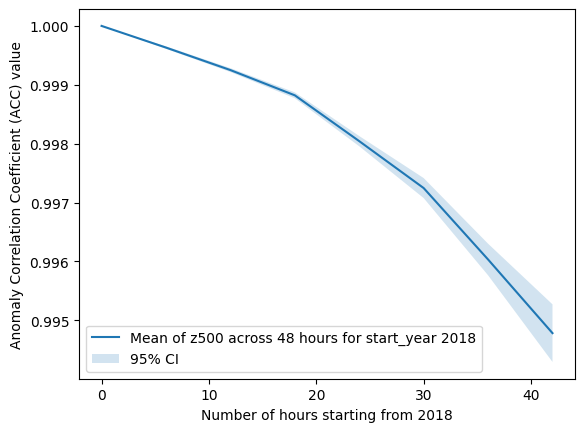

In [33]:
main(args)